使用設備: cuda
正在整理 2751 張 Forged 影像...


C:\Users\user\anaconda3\envs\pytorch_gpu\Lib\site-packages\transformers\image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


  0%|          | 0/2751 [00:00<?, ?it/s]

正在整理 2377 張 Authentic 影像...


  0%|          | 0/2377 [00:00<?, ?it/s]

✅ 總樣本數: 5128
正在載入 Mask2Former (Swin-Tiny)...


Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-tiny-coco-instance and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([81]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_predictor.weight: found shape torch.Size([81, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([81]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- 開始訓練 10 個 Epochs ---


Epoch 1 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 1 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 7.0533 | Val Loss: 6.1182
🌟 Val Loss 改善，模型已儲存！


Epoch 2 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 2 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 5.9133 | Val Loss: 5.9931
🌟 Val Loss 改善，模型已儲存！


Epoch 3 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 3 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 5.6559 | Val Loss: 5.9141
🌟 Val Loss 改善，模型已儲存！


Epoch 4 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 4 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 5.4895 | Val Loss: 5.8406
🌟 Val Loss 改善，模型已儲存！


Epoch 5 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 5 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 5.5806 | Val Loss: 5.6344
🌟 Val Loss 改善，模型已儲存！


Epoch 6 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 6 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 4.9715 | Val Loss: 5.4370
🌟 Val Loss 改善，模型已儲存！


Epoch 7 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 7 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 5.3765 | Val Loss: 5.2421
🌟 Val Loss 改善，模型已儲存！


Epoch 8 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 8 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 5.0807 | Val Loss: 5.1169
🌟 Val Loss 改善，模型已儲存！


Epoch 9 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 9 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 4.4731 | Val Loss: 5.1520


Epoch 10 Train:   0%|          | 0/1026 [00:00<?, ?it/s]

Epoch 10 Val:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 5.0908 | Val Loss: 5.1321
訓練完成！

--- 預覽 Mask2Former 效果 ---


C:\Users\user\AppData\Local\Temp\ipykernel_26164\2614092175.py:267: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_mask2former.pt

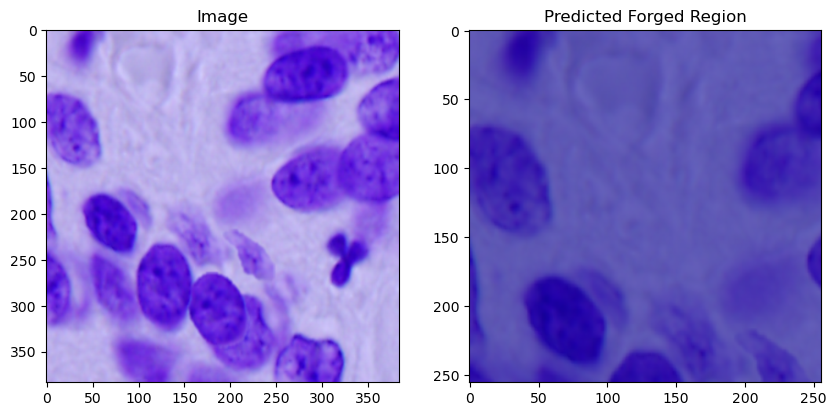

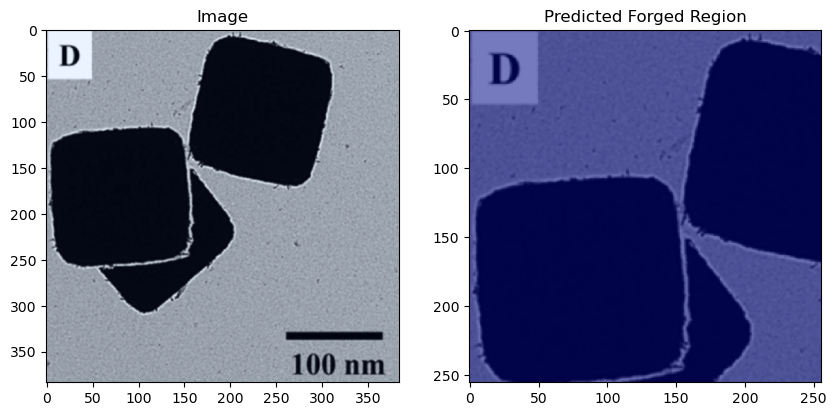

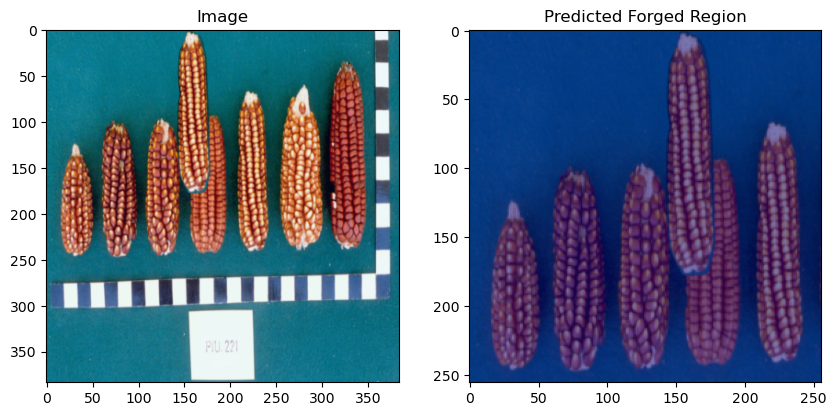

In [3]:
# ==================================================================================
# 圖像偽造檢測 (Image Forgery Detection) - Swin Transformer + Mask2Former
# 基於 Hugging Face Transformers
# ==================================================================================

import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from transformers import (
    Mask2FormerForUniversalSegmentation, 
    AutoImageProcessor, 
    get_scheduler
)
import evaluate # Hugging Face Evaluate

# ==========================================
# 1. 設定與參數
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用設備: {device}")

# 模型 Checkpoint (Swin-Tiny Backbone)
# 這是 Hugging Face 上預訓練好的 Mask2Former 模型
MODEL_CHECKPOINT = "facebook/mask2former-swin-tiny-coco-instance"

# 訓練參數
BATCH_SIZE = 4  # Mask2Former 比較吃顯存，建議從 4 開始
NUM_EPOCHS = 10 
LEARNING_RATE = 5e-5

# 資料路徑
BASE_DIR = 'dataset'
AUTHENTIC_IMG_DIR = os.path.join(BASE_DIR, 'train_images', 'authentic')
TRAIN_IMG_DIR = os.path.join(BASE_DIR, 'train_images', 'forged')
TRAIN_MASK_DIR = os.path.join(BASE_DIR, 'train_masks')

# 初始化處理器 (負責 Resize, Normalize, Format Conversion)
# ignore_mismatched_sizes=True 是因為我們要微調類別數
processor = AutoImageProcessor.from_pretrained(MODEL_CHECKPOINT)

# ==========================================
# 2. 資料集準備
# ==========================================
# 2.1 讀取 Forged
forged_data = []
forged_paths = glob.glob(os.path.join(TRAIN_IMG_DIR, '*.*'))
print(f"正在整理 {len(forged_paths)} 張 Forged 影像...")
for img_path in tqdm(forged_paths):
    case_id = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = os.path.join(TRAIN_MASK_DIR, case_id + '.npy')
    if os.path.exists(mask_path):
        forged_data.append({'image_path': img_path, 'mask_path': mask_path, 'label': 1})
        
# 2.2 讀取 Authentic
authentic_data = []
auth_paths = glob.glob(os.path.join(AUTHENTIC_IMG_DIR, '*.*'))
print(f"正在整理 {len(auth_paths)} 張 Authentic 影像...")
for img_path in tqdm(auth_paths):
    authentic_data.append({'image_path': img_path, 'mask_path': None, 'label': 0})

df_train_full = pd.concat([pd.DataFrame(forged_data), pd.DataFrame(authentic_data)], ignore_index=True)
print(f"✅ 總樣本數: {len(df_train_full)}")

# ==========================================
# 3. Dataset 定義 (適配 Mask2Former)
# ==========================================
class ForgeryMask2FormerDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['image_path']).convert("RGB")
        
        # 讀取/生成 Mask
        if row['mask_path'] is not None:
            mask_np = np.load(row['mask_path']).astype(np.uint8)
            if mask_np.ndim > 2: mask_np = mask_np[..., 0]
            mask_np = mask_np.squeeze()
        else:
            # Authentic 圖像：全黑 Mask
            mask_np = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
            
        # Mask2Former 需要 Instance/Semantic Map
        inputs = self.processor(
            images=image,
            segmentation_maps=Image.fromarray(mask_np),
            return_tensors="pt"
        )
        
        # 💥 修正：mask_labels 和 class_labels 是 List，不能用 squeeze()
        # 我們直接取 List 中的第一個元素 (因為我們每次只處理一張圖)
        return {
            "pixel_values": inputs.pixel_values.squeeze(0), # Tensor: (1, 3, H, W) -> (3, H, W)
            "mask_labels": inputs.mask_labels[0],           # List[Tensor] -> Tensor
            "class_labels": inputs.class_labels[0]          # List[Tensor] -> Tensor
        }

# ==========================================
# 4. DataLoader 與 Collate Function
# ==========================================
# Mask2Former 的 mask_labels 是 List[Tensor] 結構，需要特殊的 collate_fn
def collate_fn(batch):
    pixel_values = torch.stack([x["pixel_values"] for x in batch])
    mask_labels = [x["mask_labels"] for x in batch]
    class_labels = [x["class_labels"] for x in batch]
    return {"pixel_values": pixel_values, "mask_labels": mask_labels, "class_labels": class_labels}

from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_train_full, test_size=0.2, stratify=df_train_full['label'], random_state=42)

train_ds = ForgeryMask2FormerDataset(df_train, processor)
val_ds = ForgeryMask2FormerDataset(df_val, processor)

# Weighted Sampler (邏輯同前)
train_labels = df_train['label'].values
class_counts = np.array([len(np.where(train_labels == t)[0]) for t in [0, 1]])
weights = 1.0 / class_counts
sample_weights = np.array([weights[t] for t in train_labels])
sampler = WeightedRandomSampler(sample_weights, len(train_labels), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, collate_fn=collate_fn, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

# ==========================================
# 5. 模型載入 (Hugging Face)
# ==========================================
print(f"正在載入 Mask2Former (Swin-Tiny)...")

# 定義標籤映射 (背景=0, 偽造=1)
id2label = {0: "background", 1: "forged"}
label2id = {"background": 0, "forged": 1}

model = Mask2FormerForUniversalSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True, # 忽略類別數不匹配的警告
)
model.to(device)

# 優化器與排程器
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
lr_scheduler = get_scheduler(
    "cosine", # Cosine Decay
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=NUM_EPOCHS * len(train_loader),
)

# ==========================================
# 6. 訓練與驗證迴圈
# ==========================================
best_val_loss = float('inf')

print(f"\n--- 開始訓練 {NUM_EPOCHS} 個 Epochs ---")

for epoch in range(NUM_EPOCHS):
    # --- 訓練 ---
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Train"):
        pixel_values = batch["pixel_values"].to(device)
        mask_labels = [x.to(device) for x in batch["mask_labels"]]
        class_labels = [x.to(device) for x in batch["class_labels"]]
        
        optimizer.zero_grad()
        
        # Mask2Former 的 forward 會自動計算 Loss (包含 Dice, CrossEntropy 等)
        outputs = model(
            pixel_values=pixel_values,
            mask_labels=mask_labels,
            class_labels=class_labels,
        )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # --- 驗證 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Val"):
            pixel_values = batch["pixel_values"].to(device)
            mask_labels = [x.to(device) for x in batch["mask_labels"]]
            class_labels = [x.to(device) for x in batch["class_labels"]]
            
            outputs = model(
                pixel_values=pixel_values,
                mask_labels=mask_labels,
                class_labels=class_labels,
            )
            val_loss += outputs.loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_mask2former.pth')
        print(f"🌟 Val Loss 改善，模型已儲存！")

print("訓練完成！")

# ==========================================
# 7. 視覺化預覽
# ==========================================
# 簡單的視覺化邏輯 (因 Mask2Former 輸出格式複雜，這裡簡化為取 Class 1 的 Mask)
def visualize_mask2former(model, loader, device, num_samples=3):
    model.eval()
    batch = next(iter(loader))
    
    pixel_values = batch["pixel_values"].to(device)
    # Mask2Former 推論時不傳入 labels
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
    
    # 後處理：將預測轉換為語義分割圖 (H, W)
    # 使用 processor.post_process_semantic_segmentation
    # target_sizes 是每張圖的原始尺寸，這裡我們用處理後的大小
    target_sizes = [(256, 256) for _ in range(len(pixel_values))]
    predicted_semantic_maps = processor.post_process_semantic_segmentation(
        outputs, target_sizes=target_sizes
    )
    
    for i in range(min(len(pixel_values), num_samples)):
        # 圖像反標準化
        img = pixel_values[i].cpu().permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min()) # 簡單 MinMax 歸一化顯示
        
        # 預測 Mask (Class 1 = Forged)
        # semantic_map 是 (H, W)，值為類別 ID (0 或 1)
        pred_mask = predicted_semantic_maps[i].cpu().numpy()
        pred_forged = (pred_mask == 1).astype(np.float32)
        
        # 真實 Mask (還原)
        # 這裡稍複雜，因為 loader 裡的 mask_labels 是 list，我們只取第一個做示意
        # 實際應用建議從 Dataset 直接取原始 mask 對照
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img)
        ax[0].set_title("Image")
        ax[1].imshow(img)
        ax[1].imshow(pred_forged, cmap='jet', alpha=0.5)
        ax[1].set_title("Predicted Forged Region")
        plt.show()

print("\n--- 預覽 Mask2Former 效果 ---")
model.load_state_dict(torch.load('best_model_mask2former.pth'))
visualize_mask2former(model, val_loader, device)